## Data 100 Final Project - COVID19 Dataset

Aislin Liu, Anand Chandra

In [96]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap 
import seaborn as sns
#sklearn imports
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

Our overarching question we are hoping to model is how many days from the start of data collection (1/22/20) does it take a county to reach an established threshold of "dangerous"? We defined this "dangerous" threshold as 2% infection of the county's population.

In [97]:
abridged_counties = pd.read_csv("abridged_couties.csv")
abridged_counties.head(30)
#FIRST: data cleaning for the Gregorian dates to datetime format
#Convert the Gregorian dates to normal readable datetime format
#Columns that need this: "stay at home", ">50 gatherings", ">500 gatherings", "public schools", "restaurant dine-in", "entertainment/gym", "federal guidelines", "foreign travel ban"
#Had to write a method for this since the pd.Timestamp.fromordinal() method only takes in scalars
def ordinalToTimeStamp(series):
    arr = []
    array_form = series.values
    for o_date in array_form:
        if not math.isnan(o_date):
            arr.append(pd.Timestamp.fromordinal(int(o_date)))
        else:
            arr.append(o_date)
    return arr
gregorian = ["stay at home", ">50 gatherings", ">500 gatherings", "public schools", "restaurant dine-in", "entertainment/gym", "federal guidelines", "foreign travel ban"]
for column in gregorian:
    abridged_counties[column] = ordinalToTimeStamp(abridged_counties[column])
#Dropping some columns that I won't be basing analysis off just to have cleaner tables to look at
abridged_counties = abridged_counties.drop(["lat", "lon", "POP_LATITUDE", "POP_LONGITUDE", "CensusRegionName", "CensusDivisionName"], axis=1)
abridged_counties
print(abridged_counties.columns)
#SECOND: normalizing # of hospitals in county so they are compared evenly by representing as hospitals per capita
abridged_counties["Hospitals Per Capita"] = abridged_counties["#Hospitals"] / abridged_counties["PopulationEstimate2018"]
abridged_counties["HPSAShortage"].value_counts()

Index(['countyFIPS', 'STATEFP', 'COUNTYFP', 'CountyName', 'StateName', 'State',
       'Rural-UrbanContinuumCode2013', 'PopulationEstimate2018',
       'PopTotalMale2017', 'PopTotalFemale2017', 'FracMale2017',
       'PopulationEstimate65+2017', 'PopulationDensityperSqMile2010',
       'CensusPopulation2010', 'MedianAge2010', '#EligibleforMedicare2018',
       'MedicareEnrollment,AgedTot2017', '3-YrDiabetes2015-17',
       'DiabetesPercentage', 'HeartDiseaseMortality', 'StrokeMortality',
       'Smokers_Percentage', 'RespMortalityRate2014', '#FTEHospitalTotal2017',
       'TotalM.D.'s,TotNon-FedandFed2017', '#HospParticipatinginNetwork2017',
       '#Hospitals', '#ICU_beds', 'dem_to_rep_ratio', 'PopMale<52010',
       'PopFmle<52010', 'PopMale5-92010', 'PopFmle5-92010', 'PopMale10-142010',
       'PopFmle10-142010', 'PopMale15-192010', 'PopFmle15-192010',
       'PopMale20-242010', 'PopFmle20-242010', 'PopMale25-292010',
       'PopFmle25-292010', 'PopMale30-342010', 'PopFmle30-342010'

0.8000     13
0.4700     12
0.6300     11
0.7100     11
0.3600     11
           ..
14.0500     1
3.4100      1
1.3815      1
23.1202     1
2.6000      1
Name: HPSAShortage, Length: 910, dtype: int64

In the cell below, we did data cleaning for "confirmed" dataset. We removed all nulls and replaced it with appropriate values. In the "Admin2" column, nulls were replaced with empty string for when the data point had no county name stored. All areas/regions that had NaN for "FIPS" column is because they were not an actual county but still a group of people with noteworthy virus infection like correctional facilities. No actual US county has a FIPS of 0 so we filled these nulls in with 0. 

In [98]:
confirmed = pd.read_csv("time_series_covid19_confirmed_US.csv")
print("There are currently " + str(confirmed.isna().sum().sum()) + " NaN values in confirmed")
confirmed["Admin2"].fillna("", inplace=True)
confirmed["FIPS"].fillna(0, inplace=True)
print("There are now " + str(confirmed.isna().sum().sum()) + " NaN values in confirmed")
print(confirmed.columns)
# confirmed.shape

There are currently 11 NaN values in confirmed
There are now 0 NaN values in confirmed
Index(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_', 'Combined_Key', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20',
       '1/30/20', '1/31/20', '2/1/20', '2/2/20', '2/3/20', '2/4/20', '2/5/20',
       '2/6/20', '2/7/20', '2/8/20', '2/9/20', '2/10/20', '2/11/20', '2/12/20',
       '2/13/20', '2/14/20', '2/15/20', '2/16/20', '2/17/20', '2/18/20',
       '2/19/20', '2/20/20', '2/21/20', '2/22/20', '2/23/20', '2/24/20',
       '2/25/20', '2/26/20', '2/27/20', '2/28/20', '2/29/20', '3/1/20',
       '3/2/20', '3/3/20', '3/4/20', '3/5/20', '3/6/20', '3/7/20', '3/8/20',
       '3/9/20', '3/10/20', '3/11/20', '3/12/20', '3/13/20', '3/14/20',
       '3/15/20', '3/16/20', '3/17/20', '3/18/20', '3/19/20', '3/20/20',
       '3/21/20', '3/22/20', '3/23/20', '3/24/20', '3/25/20', '3/26/20',
       '3/27/2

In the couple cells below, we began with exploring the idea of "threshold level of dangerous" and how many days since infection it took a county to reach this threshold. We defined this threshold as a certain proportion of the county's population being confirmed COVID19 cases in order to normalize against variance in the data points caused by counties with higher populations or lower populations. We were hoping to model the idea of taking into account features like SVIPercentile and recent confirmed case counts to predict in how many days a county will reach "dangerous" levels of infection. This idea was abandoned because as we lowered this "threshold" proportion of the county infected to a level we don't believe is very meaningful, we still had very few counties even pass this threshold in the 87 days since data collection began. This would lead to minimal data to train on and a large proportion of counties to predict on which would make constructing an accurate model for the 3000 counties yet to surpass an unlikely feat.

In [99]:
#Code that constructs an array 'days' that holds all the days we are tracking over
#Done for simplicity purposes to iterate through the dataframe from each day
days = []
month = 1
day = 22
while month <= 4:
    if month == 1 and day == 32:
        month = 2
        day = 1
        continue
    elif month == 2 and day == 30:
        month = 3
        day = 1
        continue
    elif month == 3 and day == 32:
        month = 4
        day = 1
        continue
    elif month == 4 and day == 19:
        break
    else:
        date = str(month) + "/" + str(day) + "/20"
        days.append(date)
        day += 1

In [154]:
#Creation of county_cases dataframe that has a column for how many days since 1/22/20 it took a county to
#surpass a defined threshold, originally 2% of the population, but we began lowering it to see what happens.
#NOTE: This was just exploratory as it ended up not working but if it did work I would have changed the column
#to be days since first confirmed case the threshold was reached, but I ended up finding this route was not worth 
#pursuing in general.
county_cases = confirmed.join(abridged_counties, how="left", on="UID")
#Remove counties with no cases because cannot determine when it will pass a threshold without a first case for growth
county_cases = county_cases[county_cases["4/18/20"] != 0]
days_to_surpass = []
indicator = []
first_infection = []
threshold = .000000000001
for i in range(county_cases.shape[0]):
    row = county_cases.iloc[i]
    for j in range(len(days)):
        day = days[j]
        proportion = row[day] / row["PopulationEstimate2018"]
        if j == len(days) - 1:
            days_to_surpass.append(999)
            indicator.append(0)
            first_infection.append(j)
        if proportion > threshold:
            days_to_surpass.append(j)
            indicator.append(1)
            break
county_cases["days_to_surpass"] = days_to_surpass
county_cases["indicator"] = indicator
#Separating counties that passed the threshold(lowered way further than I was expecting to) and those that haven't
already_passed = county_cases[county_cases["days_to_surpass"] != 999]
havent_passed = county_cases[county_cases["days_to_surpass"] == 999]
print(str(already_passed.shape[0]) + " counties have already passed your defined threshold of " + str(threshold))
print(str(havent_passed.shape[0]) + " counties have yet to pass your threshold")
#I realized that even though the set threshold was extremely low now, the large, large majority of counties had
#yet to pass the threshold so the size of my set for training was so much smaller than what I had to test on
#which would lead to a poor model that couldn't predict accurately
county_cases["days_to_surpass"].value_counts()

4 counties have already passed your defined threshold of 1e-12
2734 counties have yet to pass your threshold


999    2734
0         4
Name: days_to_surpass, dtype: int64

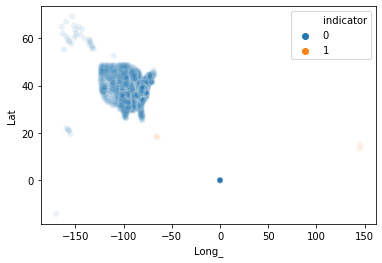

In [142]:
# no_outlier = county_cases[county_cases["dem_to_rep_ratio"] < 5]
# sns.scatterplot(data=no_outlier, x="dem_to_rep_ratio", y='MedicareEnrollment,AgedTot2017', hue="indicator")
sns.scatterplot(data=county_cases, x="Long_", y="Lat", hue="indicator", alpha=.1)

We realized that using number of days to reach the defined threshold of dangerous to quantify the danger levels was unideal since it seems the threshold would likely need to be super, super low to account for the data we had. We moved on to explore using the variable of the max proportion of the population that is infected/confirmed at a given time to quantify dangerous levels of infection.

In [103]:
days = ["4/16/20", "4/17/20"] #just 4/17/20
model = Pipeline([
    ("SelectColumns", ColumnTransformer([("keep", "passthrough", days)])),
    ("DecisionTree", LinearRegression())
])
model.fit(train[days], train["4/18/20"])
models["h+a+svi+dr+hpsa"] = model
test_mse = mean_squared_error(test["4/18/20"], model.predict(test[days]))
train_mse = mean_squared_error(train["4/18/20"], model.predict(train[days]))
(train_mse, test_mse)

(1732.2435320384398, 1226.4360412864269)

In [104]:
days = ["4/15/20", "4/16/20", "4/17/20"] #just 4/17/20
model = Pipeline([
    ("SelectColumns", ColumnTransformer([("keep", "passthrough", days)])),
    ("DecisionTree", LinearRegression())
])
model.fit(train[days], train["4/18/20"])
models["h+a+svi+dr+hpsa"] = model
test_mse = mean_squared_error(test["4/18/20"], model.predict(test[days]))
train_mse = mean_squared_error(train["4/18/20"], model.predict(train[days]))
(train_mse, test_mse)

(1687.016629862062, 1492.0127999796691)

In [105]:
#interestingly, testing from previous days is really good at predicting 4/18 infection so likely we can predict 4/19 infection?
decision_tree_model = tree.DecisionTreeRegressor(random_state=42)
train, test = train_test_split(confirmed, test_size=.25, random_state=42)
decision_tree_model.fit(train[["4/16/20", "4/17/20"]], train["4/18/20"])
dt_training_accuracy = decision_tree_model.score(train[["4/16/20", "4/17/20"]], train["4/18/20"])
dt_testing_accuracy = decision_tree_model.score(test[["4/16/20", "4/17/20"]], test["4/18/20"])
mean_squared_error(test["4/18/20"], decision_tree_model.predict(test[["4/16/20", "4/17/20"]]))
# y_hat = decision_tree_model.predict(county_cases[["4/17/20", "4/18/20"]])
# for val in y_hat:
#     print(val)

2740.479969818207

In [106]:
populations = confirmed.drop(['iso2', 'iso3', 'code3', 'FIPS', 'Province_State', 'Admin2', 'Country_Region', 'Combined_Key'], axis='columns')
dates = populations.columns[1:]
populations = populations.melt(id_vars=['UID'])
populations = populations.loc[populations['value'] != 0]
# sns.barplot(x='variable', y='value', hue='UID', data=populations.head(1000))
populations.loc[populations['UID'] == 84090036]

,UID,variable,value
179003,84090036,3/14/20,25.0
195278,84090036,3/19/20,18.0
198533,84090036,3/20/20,449.0
205043,84090036,3/22/20,23.0
208298,84090036,3/23/20,107.0


In [140]:
#Finding date of first infection


,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
0,16,AS,ASM,16,60.0,,American Samoa,US,-14.2710,-170.1320,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,,Guam,US,13.4443,144.7937,...,128,130,133,133,133,133,135,135,136,136
2,580,MP,MNP,580,69.0,,Northern Mariana Islands,US,15.0979,145.6739,...,11,11,11,11,11,11,13,13,13,14
3,630,PR,PRI,630,72.0,,Puerto Rico,US,18.2208,-66.5901,...,683,725,788,897,903,923,974,1043,1068,1118
4,850,VI,VIR,850,78.0,,Virgin Islands,US,18.3358,-64.8963,...,45,50,51,51,51,51,51,51,51,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3250,84090055,US,USA,840,90055.0,Unassigned,Wisconsin,US,0.0000,0.0000,...,0,0,0,0,0,1,1,0,0,0
3251,84090056,US,USA,840,90056.0,Unassigned,Wyoming,US,0.0000,0.0000,...,0,0,0,0,0,0,0,0,0,0
3252,84099999,US,USA,840,99999.0,,Grand Princess,US,0.0000,0.0000,...,103,103,103,103,103,103,103,103,103,103
3253,84070004,US,USA,840,0.0,Michigan Department of Corrections (MDOC),Michigan,US,0.0000,0.0000,...,0,0,0,0,370,429,472,472,514,550


Text(0.5, 1.0, 'Distribution of the Max Percent of Confirmed Cases')

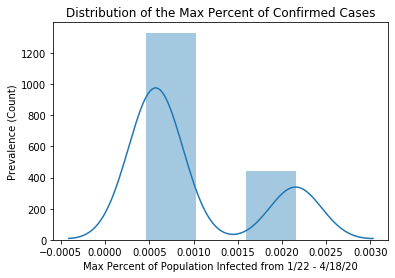

In [156]:
population_estimates = abridged_counties[['mortality2015-17Estimated', "HPSAShortage", "Rural-UrbanContinuumCode2013", "MedianAge2010", 'countyFIPS', '#Hospitals', 'PopulationEstimate2018', 'RespMortalityRate2014', 'HeartDiseaseMortality', 'dem_to_rep_ratio', "SVIPercentile", "Hospitals Per Capita"]]
population_estimates["PopulationEstimate2018"].fillna(0).astype('int64', copy=False)
confirmed_modified = confirmed.drop(['iso2', 'iso3', 'code3', 'FIPS', 'Province_State', 'Country_Region', 'Combined_Key'], axis='columns')
confirmed_modified = confirmed_modified[confirmed_modified['Admin2'] != '']
confirmed_modified = confirmed_modified[confirmed_modified['Admin2'] != 'Unassigned']
find_max = confirmed_modified.drop(['Admin2'], axis='columns')
find_max = find_max.set_index('UID')
max_vals = find_max.max(axis=1).to_frame()
confirmed_for_thresholds = confirmed[['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Combined_Key']].rename(columns={'FIPS': 'countyFIPS'})
confirmed_for_thresholds['countyFIPS'] = confirmed_for_thresholds['countyFIPS'].astype('int64').astype('str')
thresholds = confirmed_for_thresholds.merge(population_estimates, on='countyFIPS').dropna()
thresholds = thresholds.merge(max_vals, on='UID')
thresholds = thresholds.rename(columns={0: 'Max_Confirmed'})
thresholds['Max_Percent_Confirmed'] = thresholds['Max_Confirmed'] / thresholds['PopulationEstimate2018']
thresholds = thresholds[thresholds["Max_Percent_Confirmed"] != 0]
sns.distplot(thresholds["Max_Percent_Confirmed"], norm_hist=False)
plt.ylabel("Prevalence (Count)")
plt.xlabel("Max Percent of Population Infected from 1/22 - 4/18/20")
plt.title("Distribution of the Max Percent of Confirmed Cases")

The distplot showing the distribution of the "Max_Percent_Confirmed" shows that the values are largely centered within 2 ranges, what looks like approximately [.0005, .001] and [.0016, .0021]. This leads me to consider using a DecisionTreeRegressor rather than a LinearRegression model since a linear relationship would not adequately separate and represent the indicator variable, Max_Percent_Confirmed, that mostly resides in two separate ranges.

In [108]:
train, test = train_test_split(thresholds, test_size=.25, random_state=42)

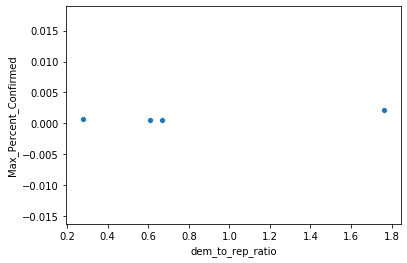

In [180]:
sns.scatterplot(data=thresholds, x="dem_to_rep_ratio", y="Max_Percent_Confirmed")
# plt.xticks(np.arange(0, .002, step=.0005))
# plt.yticks(np.arange(0, .01, step=.001))

Below, we use sklearn's Pipeline to compile a lot of different models, both LinearRegression and DecisionTreeRegressors, trained on a different selection of features to predict the max_percent_confirmed. We compare and plot the mean squared errors from each of these models, training and cross-validation, to select the one with the most ideal features as our final model.

In [168]:
models = {}
features = ["Hospitals Per Capita", "MedianAge2010", "SVIPercentile", "dem_to_rep_ratio", "HPSAShortage"]
lin_model = model = Pipeline([
    ("SelectColumns", ColumnTransformer([("keep", "passthrough", features)])),
    ("LinearModel", LinearRegression())
])
lin_model.fit(train[features], train["Max_Percent_Confirmed"])
models["lr_h+a+svi+dr+hpsa"] = lin_model

lin_model = model = Pipeline([
    ("SelectColumns", ColumnTransformer([("keep", "passthrough", features)])),
    ("DecisionTree", tree.DecisionTreeRegressor(random_state=42))
])
lin_model.fit(train[features], train["Max_Percent_Confirmed"])
models["dtree_h+a+svi+dr+hpsa"] = lin_model
test_mse = mean_squared_error(test["Max_Percent_Confirmed"], lin_model.predict(test[features]))
train_mse = mean_squared_error(train["Max_Percent_Confirmed"], lin_model.predict(train[features]))
(train_mse, test_mse)

(7.127650252757571e-09, 1.7254975132781835e-10)

In [169]:
features = ["MedianAge2010", "SVIPercentile", "dem_to_rep_ratio"]
lin_model = Pipeline([
    ("SelectColumns", ColumnTransformer([("keep", "passthrough", features)])),
    ("LinearModel", LinearRegression())
])
lin_model.fit(train[features], train["Max_Percent_Confirmed"])
models["lr_a+svi+h"] = lin_model
test_mse = mean_squared_error(test["Max_Percent_Confirmed"], lin_model.predict(test[features]))
train_mse = mean_squared_error(train["Max_Percent_Confirmed"], lin_model.predict(train[features]))
(train_mse, test_mse)

lin_model = Pipeline([
    ("SelectColumns", ColumnTransformer([("keep", "passthrough", features)])),
    ("DecisionTree", tree.DecisionTreeRegressor(random_state=42))
])
lin_model.fit(train[features], train["Max_Percent_Confirmed"])
models["dtree_a+svi+h"] = lin_model
test_mse = mean_squared_error(test["Max_Percent_Confirmed"], lin_model.predict(test[features]))
train_mse = mean_squared_error(train["Max_Percent_Confirmed"], lin_model.predict(train[features]))
(train_mse, test_mse)


(7.127650252757571e-09, 2.478474838199593e-06)

In [170]:
# features = ["MedianAge2010", "SVIPercentile", "dem_to_rep_ratio", "Hospitals Per Capita"]
# # train, test = train_test_split(thresholds, test_size=.25, random_state=42)
# lin_model = Pipeline([
#     ("SelectColumns", ColumnTransformer([("keep", "passthrough", features)])),
#     ("LinearModel", LinearRegression())
# ])
# lin_model.fit(train[features], train["Max_Percent_Confirmed"])
# models["lr_a+svi+dr+h+m"] = lin_model
# (train_mse, test_mse)

In [171]:
from sklearn.model_selection import KFold
from sklearn.base import clone

def cross_validate_mse(model):
    model = clone(model)
    five_fold = KFold(n_splits=3)
    mse_values = []
    for tr_ind, va_ind in five_fold.split(train):
        model.fit(train.iloc[tr_ind,:], train['Max_Percent_Confirmed'].iloc[tr_ind])
        mse_values.append(mean_squared_error(train['Max_Percent_Confirmed'].iloc[va_ind], model.predict(train.iloc[va_ind,:])))
    return np.mean(mse_values)


In [182]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
def compare_models(models):
    training_mse = [mean_squared_error(train['Max_Percent_Confirmed'], model.predict(train)) for model in models.values()]
    validation_mse = [cross_validate_mse(model) for model in models.values()]
    test_mse = [mean_squared_error(test['Max_Percent_Confirmed'], model.predict(test)) for model in models.values()]
    names = list(models.keys())
    fig = go.Figure([
        go.Bar(x = names, y = training_mse, name="Training MSE"),
        go.Bar(x = names, y = validation_mse, name="CV MSE"),
        go.Bar(x = names, y = test_mse, name="Validation RMSE", opacity=.2)
    ])
    return fig
fig = compare_models(models)
fig.show()

/Users/jianlin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


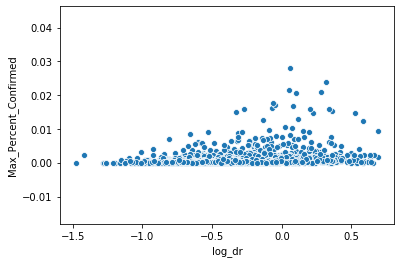

In [173]:
temp = thresholds[thresholds["dem_to_rep_ratio"] < 5]
temp["log_dr"] = np.log10(temp["dem_to_rep_ratio"])
sns.scatterplot(data=temp, x="log_dr", y="Max_Percent_Confirmed")

/Users/jianlin/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


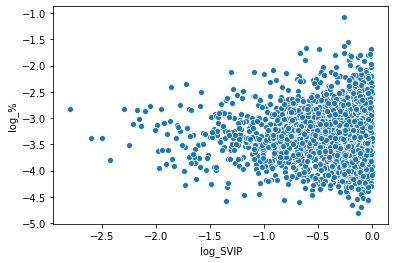

In [133]:
thresholds["log_SVIP"] = np.log10(thresholds["SVIPercentile"])
thresholds["log_%"] = np.log10(thresholds["Max_Percent_Confirmed"])
sns.scatterplot(data=thresholds, x="log_SVIP", y="log_%")

46.0

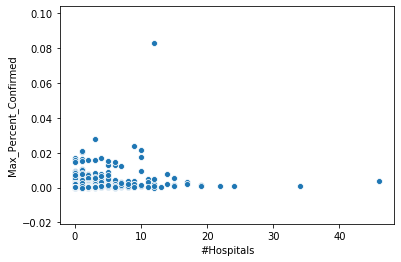

In [128]:
sns.scatterplot(data=thresholds, x="#Hospitals", y="Max_Percent_Confirmed")

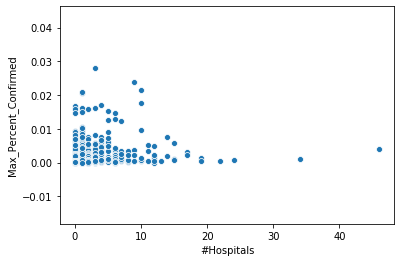

In [130]:
thresholds[thresholds["Max_Percent_Confirmed"] == max(thresholds["Max_Percent_Confirmed"])]
temp = thresholds[thresholds["UID"] != 84036061]
sns.scatterplot(data=temp, x="#Hospitals", y="Max_Percent_Confirmed")

In [139]:
train, test = train_test_split(thresholds, test_size=.25, random_state=42)
decision_tree_model = tree.DecisionTreeRegressor(random_state=42) 
decision_tree_model.fit(train[["SVIPercentile", 'HeartDiseaseMortality', 'dem_to_rep_ratio']], train["Max_Percent_Confirmed"])
dt_training_accuracy = decision_tree_model.score(train[["SVIPercentile", 'HeartDiseaseMortality', 'dem_to_rep_ratio']], train["Max_Percent_Confirmed"])
# dt_testing_accuracy = accuracy_score(test["Max_Percent_Confirmed"], decision_tree_model.predict(test[["dem_to_rep_ratio", "SVIPercentile"]]))
dt_testing_accuracy = decision_tree_model.score(test[["SVIPercentile", 'HeartDiseaseMortality', 'dem_to_rep_ratio']], test["Max_Percent_Confirmed"])
dt_testing_accuracy
y_hat = decision_tree_model.predict(test[["SVIPercentile", 'HeartDiseaseMortality', 'dem_to_rep_ratio']])
mse = mean_squared_error(test["Max_Percent_Confirmed"], y_hat)
mse

6.340652443751142e-06

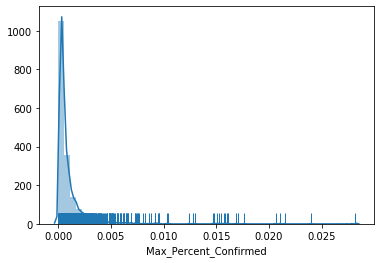

In [194]:
temp = thresholds[thresholds["Max_Percent_Confirmed"] != 0]
temp = temp[temp["Max_Percent_Confirmed"] < 0.04]
sns.distplot(temp["Max_Percent_Confirmed"], rug=True)

In [102]:
temp = county_cases[county_cases["4/18/20"] != 0]
train, test = train_test_split(temp, test_size=.25, random_state=42)
models = {}
days = ["4/17/20"] #just 4/17/20
model = Pipeline([
    ("SelectColumns", ColumnTransformer([("keep", "passthrough", days)])),
    ("DecisionTree", LinearRegression())
])
model.fit(train[days], train["4/18/20"])
models["h+a+svi+dr+hpsa"] = model
test_mse = mean_squared_error(test["4/18/20"], model.predict(test[days]))
train_mse = mean_squared_error(train["4/18/20"], model.predict(train[days]))
(train_mse, test_mse)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').